# CIFAR-10 Classification With Neuronal Network And Convolutional Layers

written by Riccard Nef in Nov-Dec 2021

#### Description
- This Notebook was created for the competence Deep Learning for the course Data Science in Brugg for FHNW.
- This task will be done with P§ytorch, there is no clear reason why not Tensorflow. 

## Table of Content

- 1. Introduction
    - 1.1 Challenge Description
- 2 Data Analysis
     - 2.0 Load Packages
    - 2.1 Implementation of Data Loading the CIFAR10 Dataset
    - 2.2 Normalizing of the Data
    - 2.3 Visualize the Dataset
    - 2.4 Distribution of the classes
    - 2.5 Metrics
    - 2.6 GPU or CPU
    - 2.7 Epochs
- 3 Implementing a complete training, testing and visualisation class
    - 3.1 My First Network: NN
        - 3.1.1 Evaluation my first NN Network
    - 3.2 Different Learning Rates
        - 3.2.1 Evaluation
    - 3.3 My First Convolutional Network : CNN1
        - 3.3.1 Evaluation of My first Convolutional Net
    - 3.4 Different Learningrate
        -  3.4.1 Evaluation
- 4 Use of Regularization
    - 4.1 L1 regularisation
        - 4.1.1 Evaluation
    - 4.2 - L2 regularisation
        - 4.2.1 Evaluation
    - 4.3 Drop Out
        - 4.3.1 Drop Out => 0.25
        - 4.3.2 Different Probability for the DropOut => 0.8
        - 4.3.3 Evaluation of Dropout(0.25) and Dropout(0.8)
- 5 Batchnorm
    - 5.1 My first Batchnorm Network
    - 5.2 Different Model
    - 5.3 Evaluation
- 6 Adam 
    - 6.1 Adam without Regression
        - 6.1.1 Evaluation
    - 6.2 Adam with L2 Regression (AdamW)
        - 6.2.1 Evaluation
    - 6.3 Adam with batchnormalisation
        - 6.3.1 Evaluation
    - 6.4 Adam with batchnormalisation with L2 Regularisation
        - 6.4.1 Evaluation
    - 6.5 Adam with Dropout
        - 6.5.1 Evaluation
    - 6.6 Adam with Batchnorm and Dropout
        - 6.6.1 Evaluation
    - 6.7 Adam with batchnrom dropout with the different model
        - 6.7.1 Evaluation
    - 6.8 Adam with Batchnorm and Regularisation with the different model
        - 6.8.1 Evaluation
- 7 Conclusion
    - 7.1 All Models plot

## 1. Introduction
### 1.1 Challenge Description

Implement, train, and validate a neural network model for a
classification task with an appropriate dataset (e.g., motion classification with the Activity
Recognition Dataset). You can propose a suitable dataset - it should not be too
large (in order to be able to evaluate many different model and parameter variants,
but also not too small, so that still reasonable ML can be done. The focus of the
mini-challenge should be on the evaluation of the model variants and settings of the
hyperparameters. Furthermore, not too sophisticated complex model architectures should be
model architectures should be investigated. A MLP for the classification with a few CNN layers for
CNN layers for feature extraction should be sufficient.
If image data is used, you can also use transfer learning to extract features from the images.
features from the images and then explore them with MLPs. 

## 2. Data Analysis
### 2.0 Load Packages
The requirented packages can also be installed with the requirment.txt file.

In [1]:
import seaborn as sns
import torch
import torchvision
from torchsummary import summary
import torchvision.transforms as transforms
import pandas as pd
import collections
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm_notebook
import torch.optim as optim
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from sklearn.metrics import f1_score,precision_score,recall_score

To check that everything worked properly, lets print the versions of all used packeges

In [2]:
print(f"package torch sucessufully loaded with version : {torch.__version__}")
print(f"package torchvision sucessufully loaded with version : {torchvision.__version__}")

package torch sucessufully loaded with version : 1.10.0+cu102
package torchvision sucessufully loaded with version : 0.11.1+cu102


### 2.1 Implementation of Data Loading the CIFAR-10 Dataset

To load the Dataset, there is a very easy way. Pytorch handels data with Dataloader Objects, witch are a part of torch.utils.data class. First you have to download the dataset into your storage, witch will be handed by torchvision. The torchvision contains the source of the ciar-10 dataset itself and is capable in downloading the dataset, store it, make train and test sets and make transformations. The transformation is basicly the normalisation, who should be used for the dataset. This normalisation will  restructure the data into numbers between -1 and 1, so the mean is 0. This makes the data into a symetric dataset, witch is good for the model.[2]


In [3]:
#normalisation with transform, numbers between -1 and 1
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

#Download of CIFAR10 Dataset with Pytorch Datasets
#Testset
testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)
#Trainset
trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)

#Dataloader with different Batchsizes [4,20,32,56,116,256,512,1024]
trainloader_batcheslist = []
testloader_batcheslist  = []
batch_sizes_list =  [4,20,32,49,116,256,512,1024,49999]
for i in batch_sizes_list:
    trainloader_batcheslist.append(torch.utils.data.DataLoader(
        trainset, batch_size=i, shuffle=True, num_workers=8
    ))
    testloader_batcheslist.append(torch.utils.data.DataLoader(
        testset, batch_size=i, shuffle=False, num_workers=8
    ))

    
batch_list_index = 3  # nr 3 in the batch_sizes_list is batchsize of 49   
trainloader = trainloader_batcheslist[batch_list_index]
testloader  = testloader_batcheslist[batch_list_index]
fullloader  = trainloader_batcheslist[-1]
batch_size  = batch_sizes_list[batch_list_index]

Files already downloaded and verified
Files already downloaded and verified


In [4]:
classes = ("plane","car","bird","cat","deer","dog","frog","horse","ship","truck")

### 2.2 Normalizing of the Data

The normalization of the data is done in pytorch by reading the data. These were normalized with the help of a transform matrix. Here the normalization is done with 0.5, which means that the mean is 0.5.


<pre><code>
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
</code></pre>


With the help of this transform matrix the data set can be stored already normalized. 

<pre><code>

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
</code></pre>

### 2.3 Visualize the Dataset

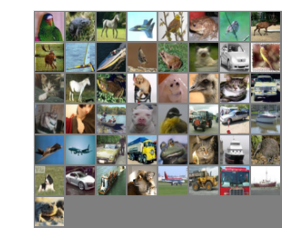

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

In [6]:
class_labels = []
for j in range(batch_size):
    class_labels.append(classes[labels[j]])
print(f"batchsize = {batch_size}\n")
print(str(class_labels)[1:-1]) 

batchsize = 49

'bird', 'frog', 'horse', 'plane', 'bird', 'frog', 'bird', 'deer', 'deer', 'ship', 'ship', 'bird', 'frog', 'dog', 'car', 'bird', 'cat', 'horse', 'frog', 'dog', 'dog', 'bird', 'cat', 'car', 'cat', 'cat', 'ship', 'dog', 'bird', 'truck', 'car', 'ship', 'plane', 'plane', 'car', 'truck', 'frog', 'cat', 'ship', 'bird', 'dog', 'car', 'ship', 'dog', 'plane', 'truck', 'truck', 'ship', 'frog'


### 2.4 Distribution of the classes

In [7]:
dataiter_full = iter(fullloader)
images_full, labels_full = dataiter_full.next()
labels_full = labels_full.detach().cpu().numpy()

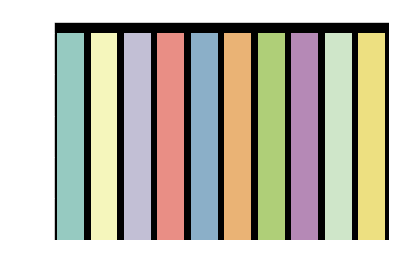

In [8]:
plot1 = sns.countplot(x=labels_full)
plot1 = plot1.set(xlabel='classes', ylabel='count',title='Distribution of Classes in CIFAR-10')
plt.show()

#### 2.4.1 Balanced Data
You see that the distribution ot the classes in the dataset is almost perfect balanced. In normal cases this will not be the case, but the ciafa-10 dataset is a made extra for training with neuronal nets. 

In [9]:
df_describe = pd.DataFrame(labels_full)
#count the labels with Counter()
distro = collections.Counter(labels_full)

for i in range(len(distro.keys())):
    print(f"Label {i+1} has {distro[i]} Datapoints")

Label 1 has 5000 Datapoints
Label 2 has 4999 Datapoints
Label 3 has 5000 Datapoints
Label 4 has 5000 Datapoints
Label 5 has 5000 Datapoints
Label 6 has 5000 Datapoints
Label 7 has 5000 Datapoints
Label 8 has 5000 Datapoints
Label 9 has 5000 Datapoints
Label 10 has 5000 Datapoints


In [10]:
def check_distro(arr):
    #indicates the average deviation of the mean value of the number of data points.
    distro = collections.Counter(arr)
    distro_mean = np.array(list(distro.values())).mean()
    counter = 0
    for i in distro.keys():
        counter+=distro[i]-distro_mean
    return counter/len(arr)

In [11]:
print(f"the average deviation is {check_distro(distro):.25f}")

the average deviation is 0.0000000000003637978807092


### 2.5 Metrics

The model is a classic classifier, which distinguishes classes. For this type of model there are a variety of possible metrics.These are:
- Train and Test Accuracy
- F1 Score
- Precision
- Recall

Something important, which is not a metric, is the confusion matrix. Here you can see the concrete "wrongness" of the prediction. For example, if the data is very unevenly distributed (i.e. there is much more of one label than others), the normal Precision or Accuracy value can only be used with great caution. For example, if you have only 2 labels and one label is 80% represented in the data set, and you have an accuracy of 80%, the model may simply attribute everything to the more represented label. You can see all of this in the cofusion matrix.

However, since my data set is almost perfectly balanced, I don't have this problem. It is still possible that my predictions are unbalanced. Therefore it is important to find a balance between precision and recall. This will be done with the f1score, but when the recall and precsion are equal, they also have the same value than the f1 score.

$$ F1 = \frac{2 \cdot precision\cdot recall}{precision+ recall} $$ <br>


### 2.6 GPU or CPU
Pytorch has a implemented method to calulate everithing with the help of the gpu power. To following code makes the variable: device, whitch will test if gpu is 

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"{device=}")

device=device(type='cuda', index=0)


In [13]:
print(f"Used Grafic-Card is called : {torch.cuda.get_device_name(0)}")

Used Grafic-Card is called : Tesla P100-PCIE-16GB


### 2.7 Epochs
To define how many epochs the programm will make for calculation, lets define a variable who sets every epochcount to the same.

In [14]:
epochs = 30

### 2.9 Batchsize

To find the optimal batch-size is really important. When the batch-size is too low the model take a lot of time to train, because it has to calculate more gradients. After my first tries with a neural net it turned out, that a batch-size of 4 was deftly to low, even the time for calculation was not that long. The model couldn't even make it over 20% accuracy. After a view tries I decided to set the batch-size to 49 because there was a slightly better performance with the Adam optimizer with 49 than with 32.

## 3 Implementing a complete training, testing and visualisation class

In [15]:
class MLP:
    def __init__(self):
        self.train_losses = []
        self.test_losses  = []
        
        self.train_acc    = []
        self.test_acc     = []        
        self.test_f1     = []
        self.test_pr     = []
        self.test_re     = []
        self.test_roc    = []
    
    def train(self, model, device, train_loader, optimizer, epoch,L1=None):
        #if the L1 variable is not None the train model will run without the L1 regularisation, the L1 value is 

        criterion = nn.CrossEntropyLoss()
        model.train()
        pbar = tqdm_notebook(train_loader)

        for batch_idx, (data, target) in enumerate(pbar):
            train_acc_t=[]
            # Laden des Datensatzes als Tensor in die GPU
            data, target = data.to(device), target.to(device)

            # Gradient nullen
            optimizer.zero_grad()

            # feed forward for the prediction 
            y_pred = model(data)

            # Calculate loss with Crossentropy(), witch already contains softmax
            loss = criterion(y_pred, target)

            # Adding code for L1 Regularisation
            if L1 is not None:
              l1_crit = nn.L1Loss()
              reg_loss = 0
              for param in model.parameters():
                  reg_loss += l1_crit(param,target=torch.zeros_like(param))
              loss += L1 * reg_loss
              self.train_losses.append(loss.item())
            else:
              self.train_losses.append(loss.item())

            # Backpropagation
            loss.backward()
            optimizer.step()
            # calculate the accuarcy ot the batch
            acc = MLP.accuracy(y_pred,target,len(data))
            # Update pbar-tqdm
            pbar.set_description(desc= f' Batch_id={batch_idx}\nLoss={loss.item():0.2f}\nAccuracy={acc:0.2f}')
            # Update accuary_list
            train_acc_t.append(acc)
        #store the mean of the accuaries of all batches
        self.train_acc.append(sum(train_acc_t)/len(train_acc_t))
       
        
    def test(self, model, device, test_loader):
        model.eval()
        test_loss = 0
        correct = 0
        f1_temp = []
        pr_temp = []
        re_temp = []

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                # sum up batch loss
                test_loss += F.nll_loss(output, target, reduction='sum').item()
                # get the index of the max log-probability
                pred = output.argmax(dim=1, keepdim=True)  
                correct += pred.eq(target.view_as(pred)).sum().item()
                f1pred = torch.reshape(pred, (-1,))
                f1_temp.append(f1_score(target.cpu(),f1pred.cpu(),average="micro"))
                pr_temp.append(precision_score(target.cpu(),f1pred.cpu(),average="micro"))
                re_temp.append(recall_score(target.cpu(),f1pred.cpu(),average="micro"))
                
          
        test_loss  /= len(test_loader.dataset)
        current_acc = 100. * correct / len(test_loader.dataset)
        current_f1  = sum(f1_temp) / len(f1_temp)
        current_pr  = sum(pr_temp) / len(pr_temp)
        current_re  = sum(re_temp) / len(re_temp)
        
        self.test_losses.append(test_loss)
        self.test_acc.append(current_acc)
        self.test_f1.append(current_f1)
        self.test_pr.append(current_pr)
        self.test_re.append(current_re)
        
        print(f"Test set ====> Average loss = {test_loss:.3f}, Accuracy = {current_acc:.3f}, F1score = {current_f1:.3f}")
        
        
        
    @staticmethod
    def accuracy(y_pred,target,length):
        correct = 0
        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        return 100*(correct/length)
            
        
    def visualizeMLP(self):
        if len(self.train_losses) == 0:
            return "no initialisation"
        else:
            fig, axs = plt.subplots(2, 2)
            fig.set_figheight(15)
            fig.set_figwidth(15)
            axs[0, 0].plot(range(len(self.test_acc)),self.test_acc)
            axs[0, 0].plot(range(len(self.train_acc)),self.train_acc)
            axs[0, 0].set_title('Test and Test Accuracy')
            axs[0, 0].set_xlabel('Epochs')
            axs[0, 0].set_ylabel('Accuracy in %')
            axs[0, 0].legend(["testaccuracy","trainaccuary"],loc="lower right")
            axs[0, 1].bar(["Train Accuracy","Test Accuracy","Test f1Score","Test Precision","Test Recall"],
                          [self.train_acc[-1],self.test_acc[-1],self.test_f1[-1]*100,self.test_pr[-1]*100,self.test_re[-1]*100],
                          color=['#97a359','#214919', '#2aada1', '#2a76ad', '#76d2cb'])
            axs[0, 1].set_title('Metrics at the end of Training')
            axs[0, 1].set_ylim([30, 100])
            axs[1, 0].plot(range(len(self.test_f1)),self.test_f1)
            axs[1, 0].set_title('f1-score')
            axs[1, 0].set_ylabel('f1 with average = micro')
            axs[1, 0].set_xlabel('Epochs')
            axs[1, 1].plot(range(len(self.test_losses)),self.test_losses)
            #axs[1, 1].plot(range(len(self.train_losses)),self.train_losses)
            axs[1, 1].set_title('Loss')
            axs[1, 1].set_ylabel('Crossentropyloss')            
            axs[1, 1].set_xlabel('Epochs')
        
    def train_model(self, epochs,model,reg=None,ext_opt=None,weight_decay=0.003, lr=0.01):
        L1= None
        if  ext_opt is not None:
            optimizer = ext_opt
        else: 
            if reg==None:
                optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
            elif reg=="L1":
                L1 = 0.001
                optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
            elif reg=="L2":
                optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9,weight_decay=weight_decay)

        for epoch in range(epochs):
            print(f"Epoch:{epoch+1}/{epochs}")
            self.train(model, device, trainloader, optimizer, epochs,L1=L1)
            self.test(model, device, testloader)

### 3.1 My First Network: NN
input = 32 * 32 * 3<br>
output = 10<br>
structure of the net : <br>
1. NN Layer (input = 32*32*3,2000)
2. NN Layer (2000, 1200)
3. NN Layer (1200, 600)
4. NN Layer (600, 84)
5. NN Layer (84, output = 10)

In [16]:
# PYtorch class for neuronal net
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(32*32*3,2000)
        self.fc2 = nn.Linear(2000, 1200)
        self.fc3 = nn.Linear(1200, 600)
        self.fc4 = nn.Linear(600, 84)
        self.fc5 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [17]:
modelNN =  NN().to(device)
summary(modelNN, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 2000]       6,146,000
            Linear-2                 [-1, 1200]       2,401,200
            Linear-3                  [-1, 600]         720,600
            Linear-4                   [-1, 84]          50,484
            Linear-5                   [-1, 10]             850
Total params: 9,319,134
Trainable params: 9,319,134
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 35.55
Estimated Total Size (MB): 35.59
----------------------------------------------------------------


In [ ]:
#training
M3_1 = MLP()
M3_1.train_model(epochs,modelNN)

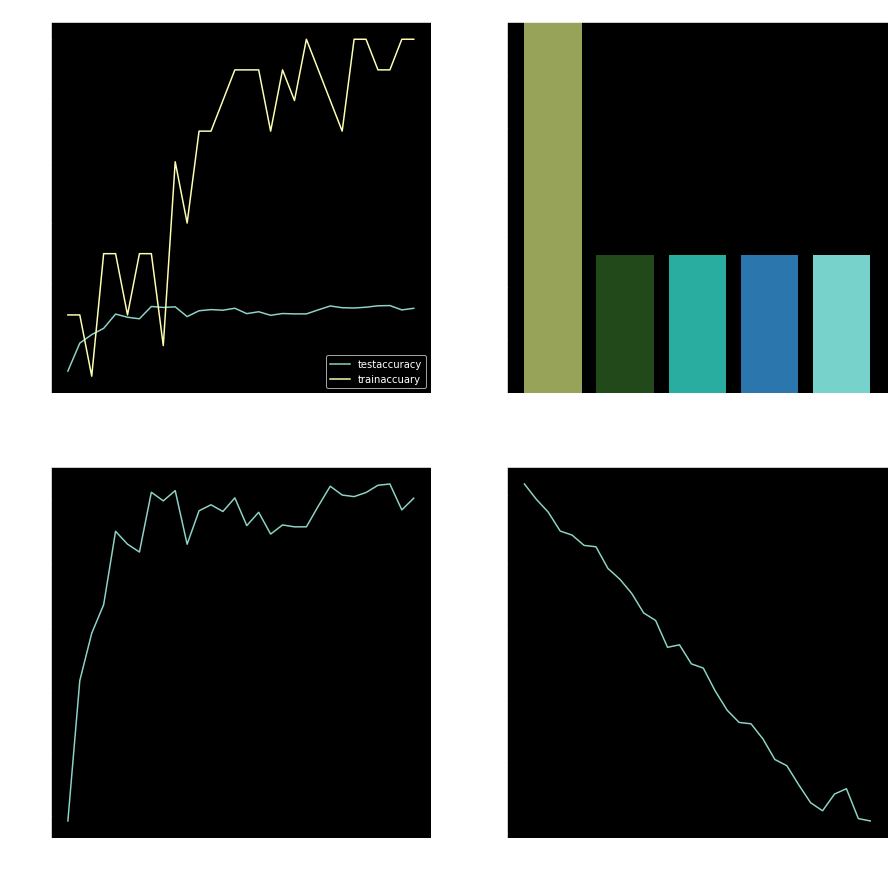

In [19]:
M3_1.visualizeMLP()

#### 3.1.1 Evaluation my first NN Network

The model is capeble of predicting almost 95% of the classes correct. However, it is only working for the trainset. That means that the model is defently overfitting. The test accuracy is raising until it hits around 55 % accuracy. Whitch is actually not that bad for a model with 10 classes. And this model should only showcase the difference between a convolution net and a normal linear net. 

- The recall, precsiion and f1 score are all the same.

### 3.2 Different Learning Rates
Lets see what happens when we devide the learningrate by 2. So the learning should be slower but it should be more accurate.

In [ ]:
#training
M3_2 = MLP()
M3_2.train_model(epochs,modelNN,lr=0.005)

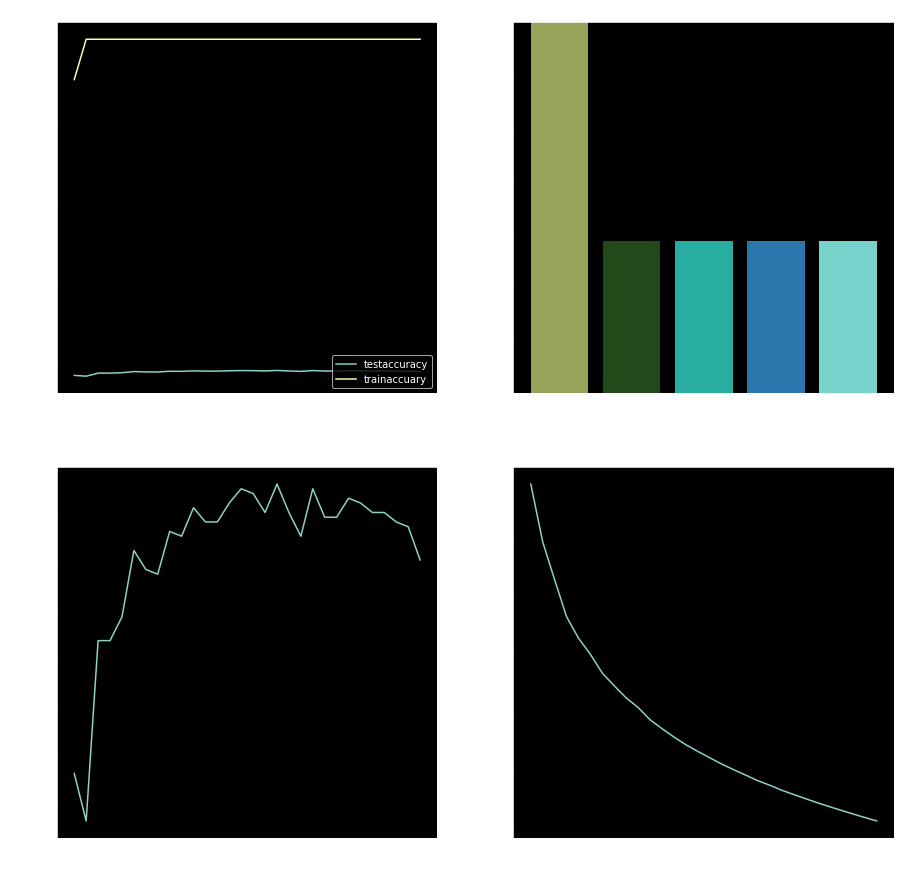

In [21]:
M3_2.visualizeMLP()

#### 3.2.1 Evaluation
The model is the epitome of an overfitting model. It is realy interesting that the train accuracy is in almost all epochs 100% and the test accurcy is almost unchanged. The test accury is also smoothing out at the end.
- The f1 score shows a complete different picture, than the accuracy. It moves realy strong up and down.

### 3.3 My First Convolutional Network : CNN1


A Convolutional Neural Network (ConvNet/CNN) is a Deep Learning algorithm which can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other. The pre-processing required in a ConvNet is much lower as compared to other classification algorithms. While in primitive methods filters are hand-engineered, with enough training, ConvNets have the ability to learn these filters/characteristics.[1]


structure of the net : <br>
input = 32 pixel * 32pixel * 3dimensions(rgb) -> so it has 3 inputchannels <br>
output = 10 classes

cnn => Outputchannels Layer1 = Inputchannels Layer2
nn  => Output Layer 1 = Input Layer2
1. convolutional Layer -> (inputchannelds = 3, outputchannels = 6, kernel = 5)
2. MxPooling -> with 2x2
3. convolutional Layer -> (inputchannelds = 6, outputchannels = 16, kernel = 5)
4. NN Layer -> input is (outputchannels(16) * kernelsize(5) * kernelsize(5) outputdim = 120)
5. NN Layer -> input(120) = outputdim(84)
6. NN Layer -> input(84) = output(10)

In [22]:
# PYtorch class for neuronal net
class CNN1(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [23]:
modelCNN1 =  CNN1().to(device)
summary(modelCNN1, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [ ]:
#training
M3_3 = MLP()
M3_3.train_model(epochs,modelCNN1)

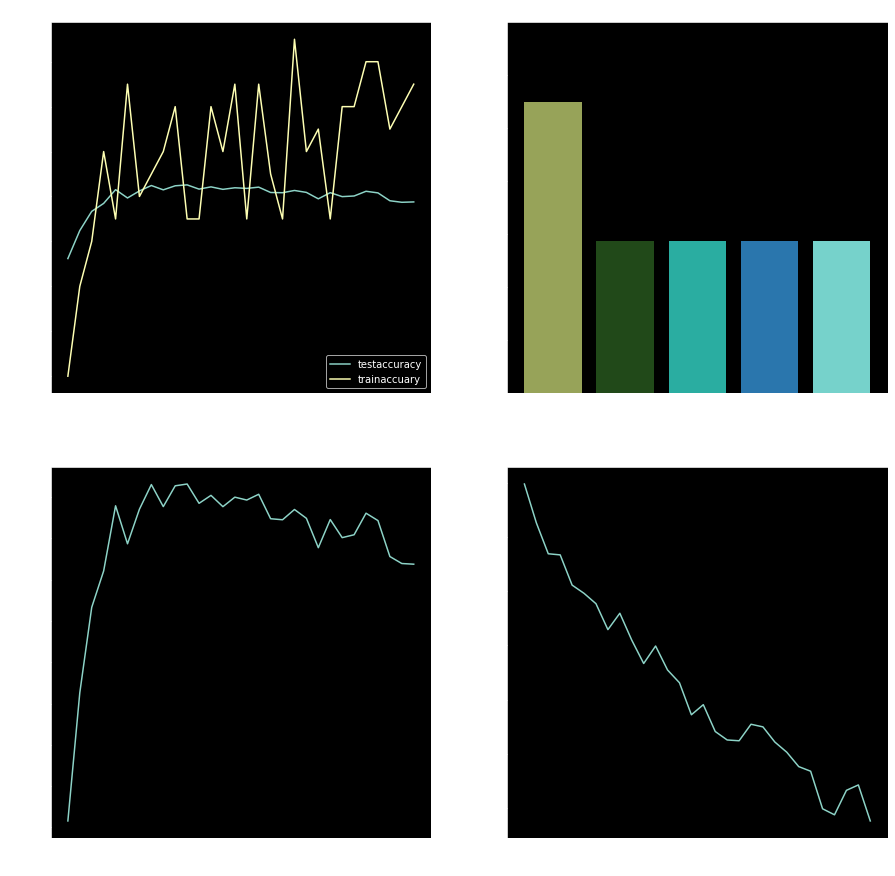

In [25]:
M3_3.visualizeMLP()

#### 3.3.1 Evaluation of My first Convolutional Net
It shows definitly a different picture of the accuracy. It is again overfitting, even when in a few epochs the train accuracy are lower than the test accuracy. The Test accuracy is around 60 % witch is better than the NN Modle, but not good enough.

- the f1,precision and recall are equal

### 3.4 Different Learningrate
In this chapter we will change the learningrate from 0.01 to 0.005. Lets see what happens.

In [ ]:
M3_4 = MLP()
M3_4.train_model(epochs,modelCNN1,lr=0.005)

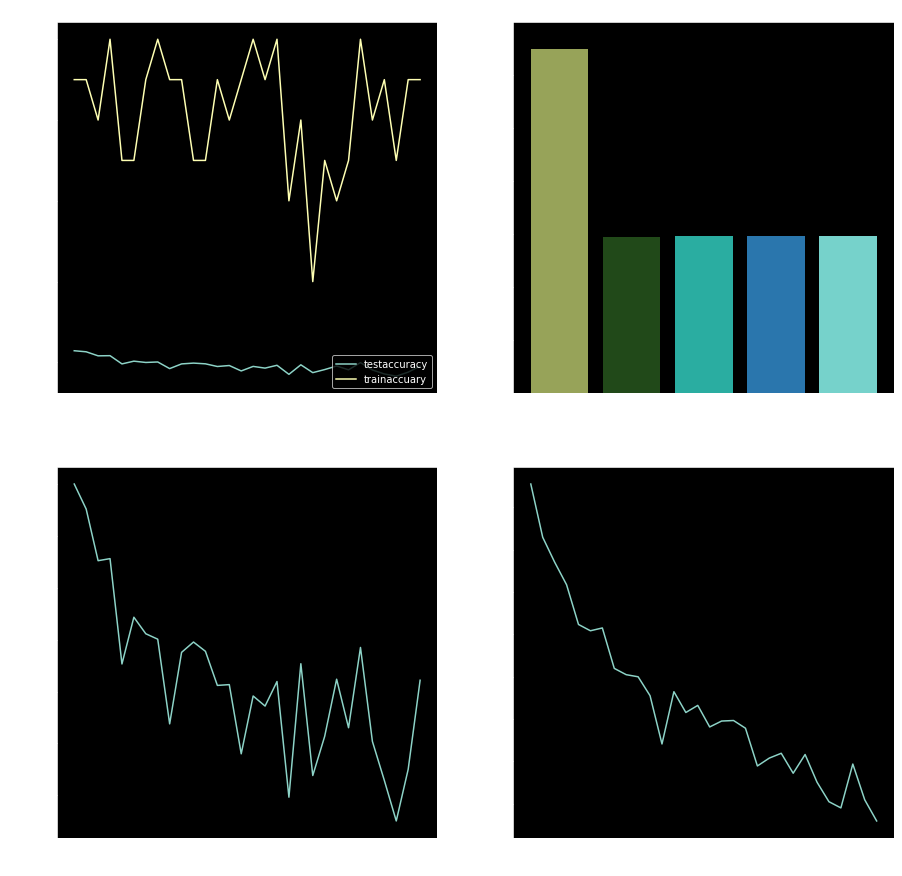

In [27]:
M3_4.visualizeMLP()

#### 3.4.1 Evaluation
The Model with the lower Learningrate works better than the model with the higher lerningrate. The testaccuracy is almost 5 % better, but it is highly overfitting. The trainaccuracy reaches even the 100 % mark. But to use this model it is indispensable to regularise the model. 

## 4  Use of Regularization
Regularisation is a common methode to reduce overfitting. The only thing, that the model is making, is reducing the loss function, it does not see a difference between a parameter who has a value of 1 Million and one who is 1, it only looks at the cost, they are causing. With the help of reglarisation it is possible the give the model this information. It is basicly expands the costfuntion with the calue of the parameters itself.
In this notebook we will analyse three variants of regularisation:

- The L1
- The L2
- The Dropout

### 4.1 - L1 regularisation
with $\alpha = 0.001$
$$L1cost = costfuntion +  \alpha \sum\left | \omega   \right |$$ 

In [ ]:
M4_1 = MLP()
M4_1.train_model(epochs,modelCNN1,reg="L1")

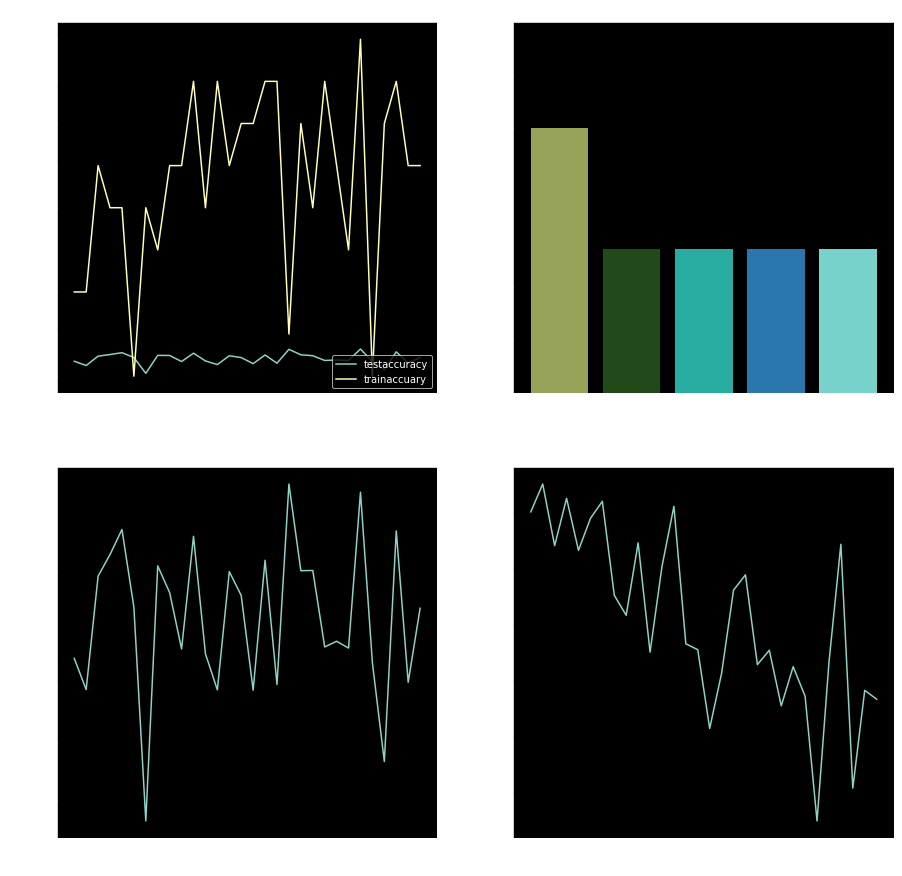

In [29]:
M4_1.visualizeMLP()

#### 4.1.1 Evaluation
There is definitly a difference between the unreglarised version of the model. The test accuracy is not realy better, but it doas not overfitt mutch. 
- the calculation of the precsion and reccal has faild somehow, witch is a bug in the programm

### 4.2 - L2 regularisation
with $\alpha = 0.03$
$$L1cost = costfuntion +  \alpha \sum\omega^{2}$$ 

In [ ]:
M4_2 = MLP()
M4_2.train_model(epochs,modelCNN1,reg="L2")

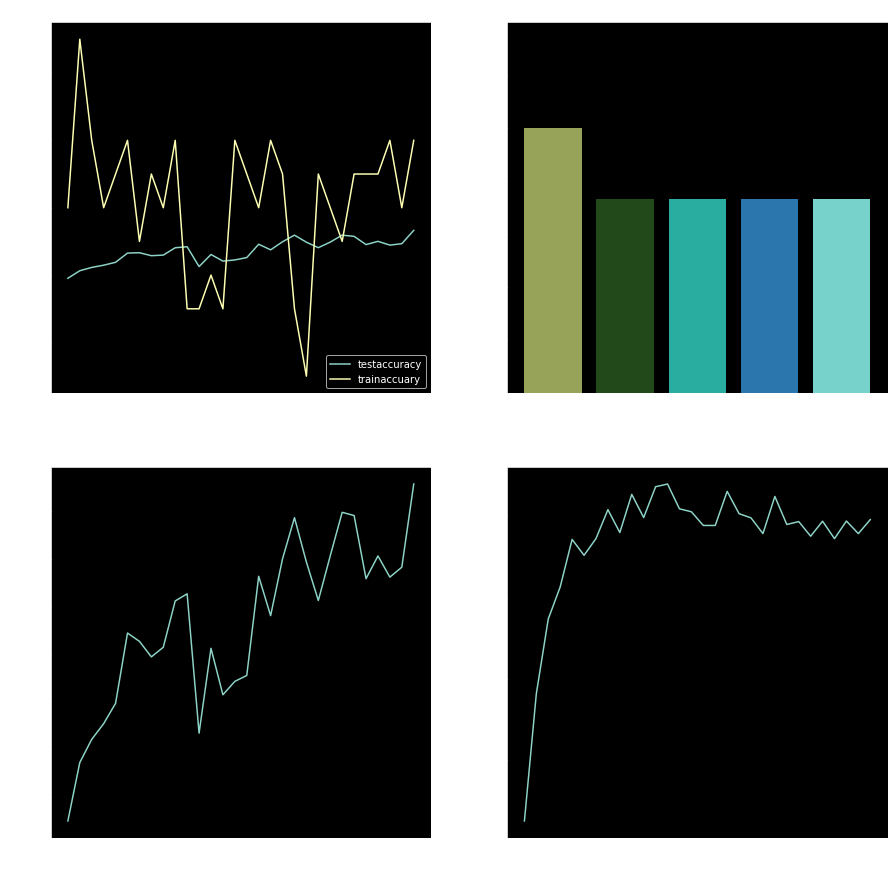

In [31]:
M4_2.visualizeMLP()

#### 4.2.1 Evaluation

It is realy interesting to see, that the model is overfitting at the beginning and tries to reduce this overfitting during the training. After 15 Epochs the overfitting is under controll. 

- precsion, recall and f1 are equal

### 4.3 Drop Out
- with Probability of 0.25
The Dropout is a additional methode to regularise the model and is described on pytoch.com as following: 

> During training, randomly zeroes some of the elements of the input tensor with probability p using samples from a Bernoulli distribution. Each channel will be zeroed out independently on every forward call.


#### 4.3.1 Drop Out => 0.25

In [32]:
class NetDropOut(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [33]:
netdropout = NetDropOut()
netdropout.to(device)
model_drop = NetDropOut().to(device)

In [ ]:
M4_3_1 = MLP()
M4_3_1.train_model(epochs,model_drop)

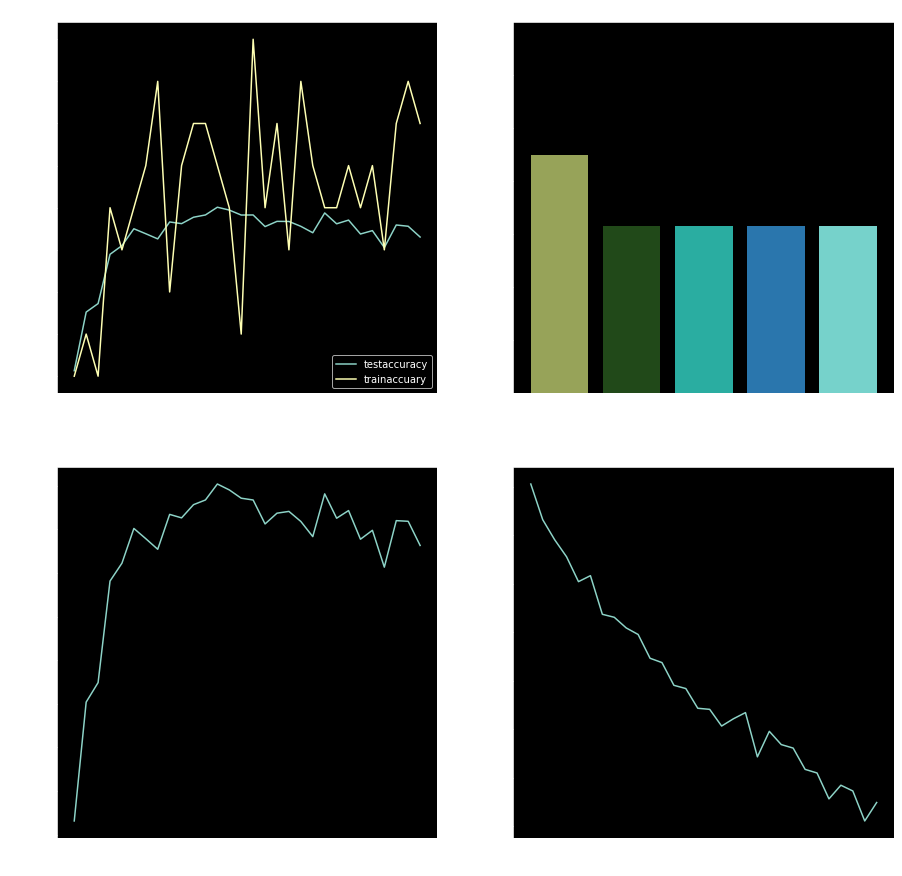

In [35]:
M4_3_1.visualizeMLP()

#### 4.3.2 Different Probability for the DropOut => 0.8

In [36]:
class NetDropOut2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.dropout = nn.Dropout(0.8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [37]:
netdropout2 = NetDropOut2()
netdropout2.to(device)
model_drop2 = NetDropOut().to(device)

In [ ]:
M4_3_2 = MLP()
M4_3_2.train_model(epochs,model_drop2)

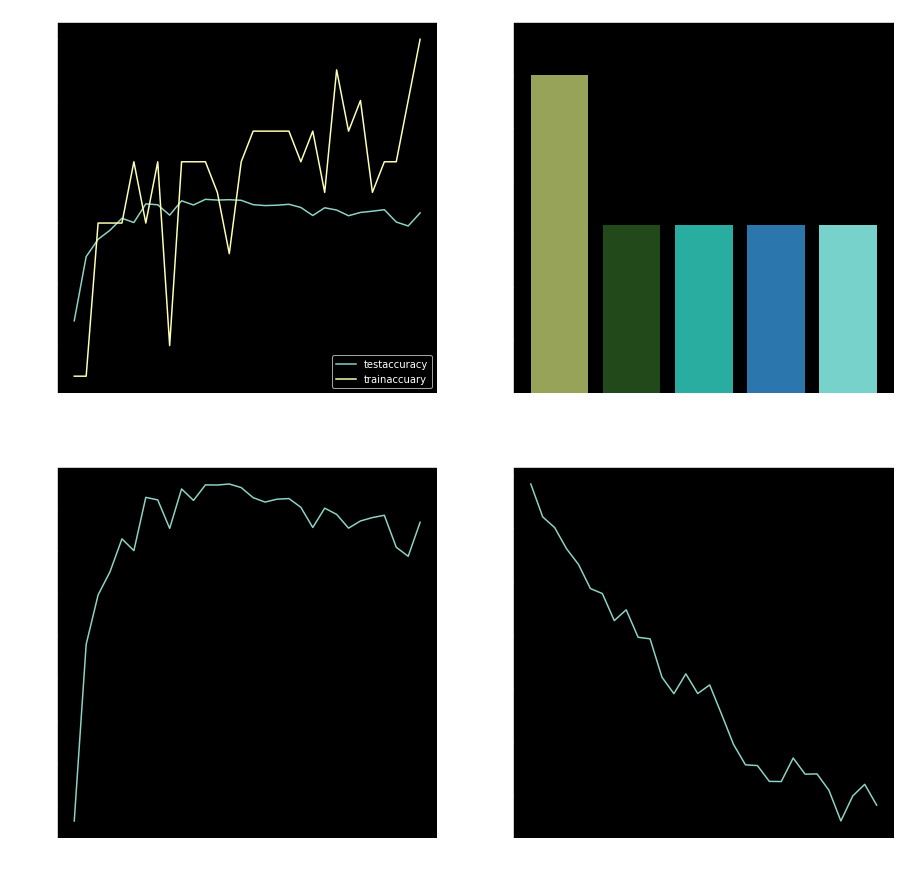

In [39]:
M4_3_2.visualizeMLP()

#### 4.3.3 Evaluation of Dropout(0.25) and Dropout(0.8)

The result of the tho models are really similar, the test accuracy and the f1-score especially. Only the train accuracy seams to be a bit different.
The train accuracy from the model with the lower probability has more spikes but the model with the higher probability seams to overfit at the end.


## 5 Batchnorm
With normalisation we normalise the input. But what happend with the hidden inputs? Here comes batchnormalisation and normalises the data.
It can be done once, like the NetbN model, or more than once, like the NetbN2 model.
- The input of a batchnorm pytorchlayer are the outputchannels of the last layer. Witch is 16 in this case.

### 5.1 My first Batchnorm Network

In [40]:
class NetbN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels= 6,kernel_size= 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bN1  = nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.bN1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [41]:
netbN = NetbN()
netbN.to(device)
model_bN = NetbN().to(device)
summary(model_bN, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
       BatchNorm2d-5             [-1, 16, 5, 5]              32
            Linear-6                  [-1, 120]          48,120
            Linear-7                   [-1, 84]          10,164
            Linear-8                   [-1, 10]             850
Total params: 62,038
Trainable params: 62,038
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [ ]:
M5_1 = MLP()
M5_1.train_model(epochs,model_bN)

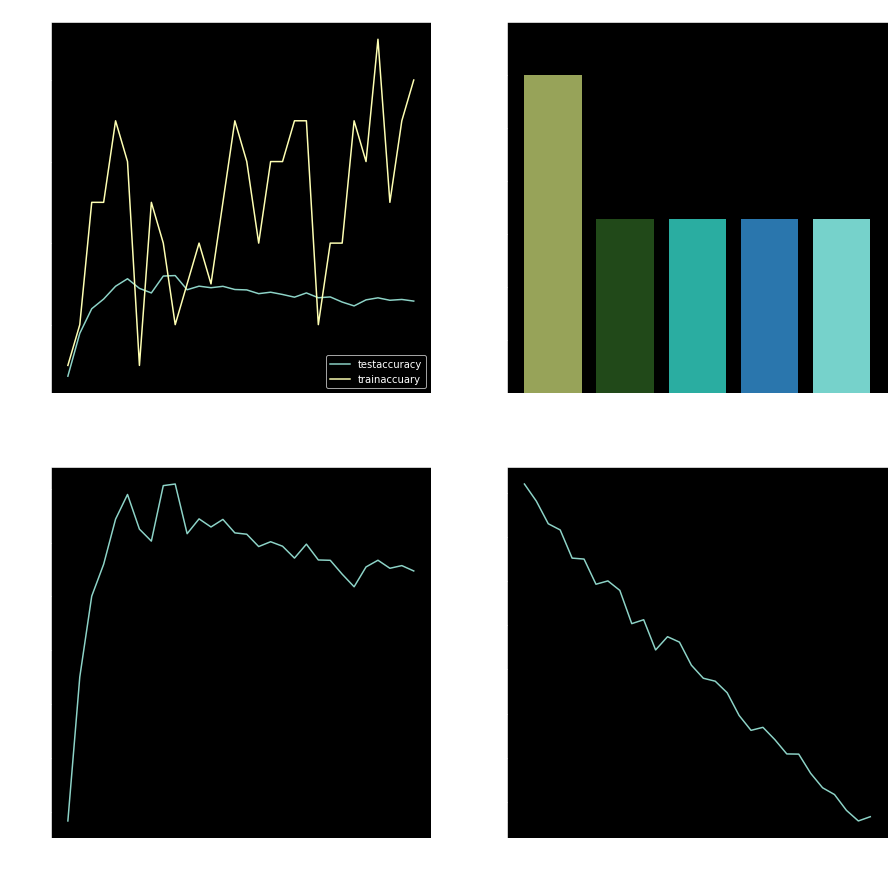

In [43]:
M5_1.visualizeMLP()

### 5.2 A more complex Model

In [44]:
class NetbN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2   = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3   = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(4*4*256, 128)
        self.fc2 = nn.Linear(128, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = self.pool1(self.relu1(x))
        x = self.bn2(self.conv2(x))
        x = self.pool2(self.relu2(x))
        x = self.bn3(self.conv3(x))
        x = self.pool3(self.relu3(x))
        s = x.view((x.shape[0], -1))
        s = self.fc1(s)
        s = self.fc2(s)
        s = self.fc3(s)
        return s

In [45]:
netbN2 = NetbN2()
netbN2.to(device)
model_bN2 = NetbN2().to(device)
summary(model_bN2, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
      BatchNorm2d-10            [-1, 256, 8, 8]             512
             ReLU-11            [-1, 256, 8, 8]               0
        MaxPool2d-12            [-1, 256, 4, 4]               0
           Linear-13                  [-1, 128]         524,416
           Linear-14                   

In [ ]:
M5_2 = MLP()
M5_2.train_model(epochs,model_bN2)

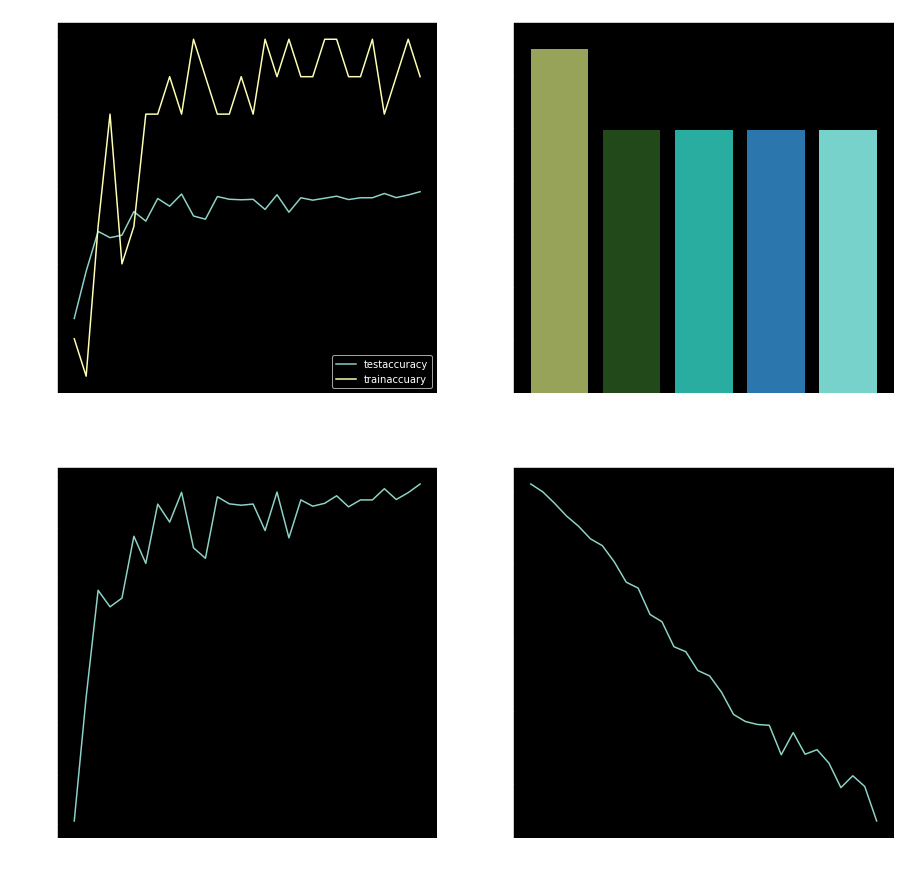

In [47]:
M5_2.visualizeMLP()

### 5.3 Evaluation
The batch-normalisation is definitely a good optimizer for the network. The model with one batch-normalisation was only around 5 % better than without but the more complex model has almost a accuracy of 80 %, which is really an improvement. But especially the better model was over-fitting.


## 6 Adam
Adam stands for adaptive learning-rate and combines two extensions of the stochastic gradient descend.
- **Adaptive Gradient Algorithm (AdaGrad)**
that maintains a per-parameter learning rate that improves performance on problems with sparse gradients (e.g. natural language and computer vision problems).[3]
- **Root Mean Square Propagation (RMSProp)**
- that also maintains per-parameter learning rates that are adapted based on the average of recent magnitudes of the gradients for the weight (e.g. how quickly it is changing). This means the algorithm does well on online and non-stationary problems (e.g. noisy).[3]




In [48]:
#Adam optimizer
AdamAlpha = 0.001
optimizerADAM  = optim.Adam(modelCNN1.parameters(), AdamAlpha)
optimizerADAMW = optim.AdamW(modelCNN1.parameters(),weight_decay=0.1)

### 6.1 Adam without Regression

In [ ]:
#without regression
M6_1 = MLP()
M6_1.train_model(epochs,modelCNN1,ext_opt = optimizerADAM)

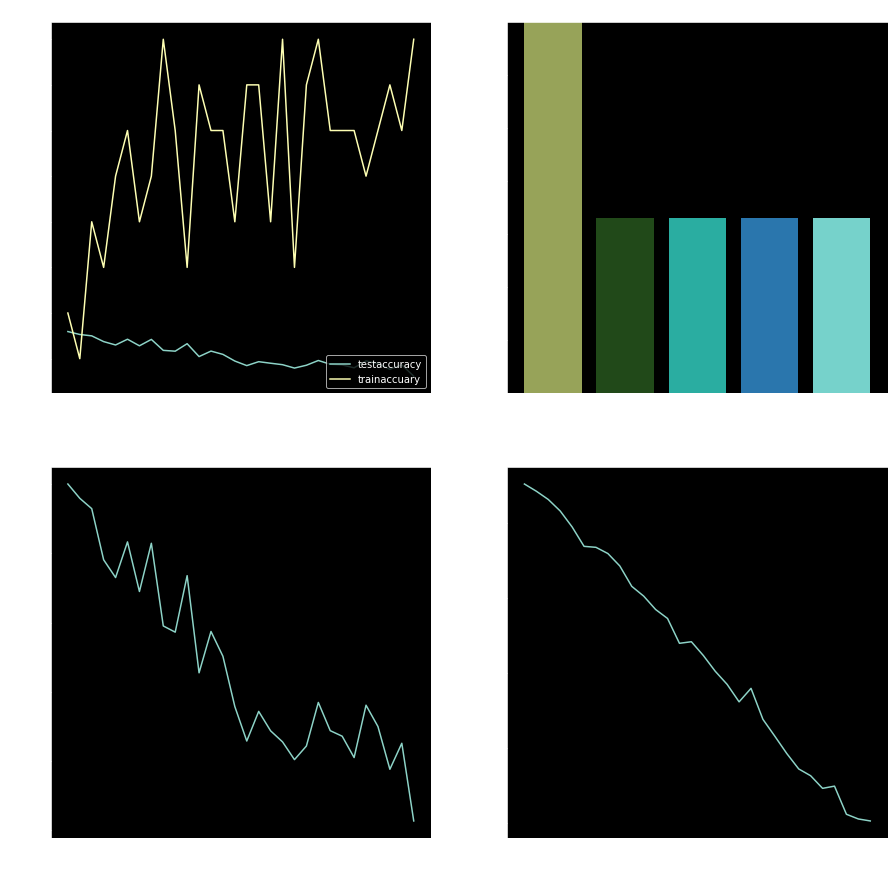

In [50]:
M6_1.visualizeMLP()

#### 6.1.1 Evaluation
The normal Convolutional Network works better with Adam but at the end of the training it is worse than at the beginning.
The Adam optimizer seems to hit a accuracy of around 65 % at the beginning with is a big improvement. One thing witch is striking is again the over-fitting.
Lets see what happens when we user a L2 Regression on the model.

### 6.2 Adam with L2 Regression (AdamW)

In [ ]:
#with l2 regression
M6_2 = MLP()
M6_2.train_model(epochs,modelCNN1,ext_opt = optimizerADAMW)

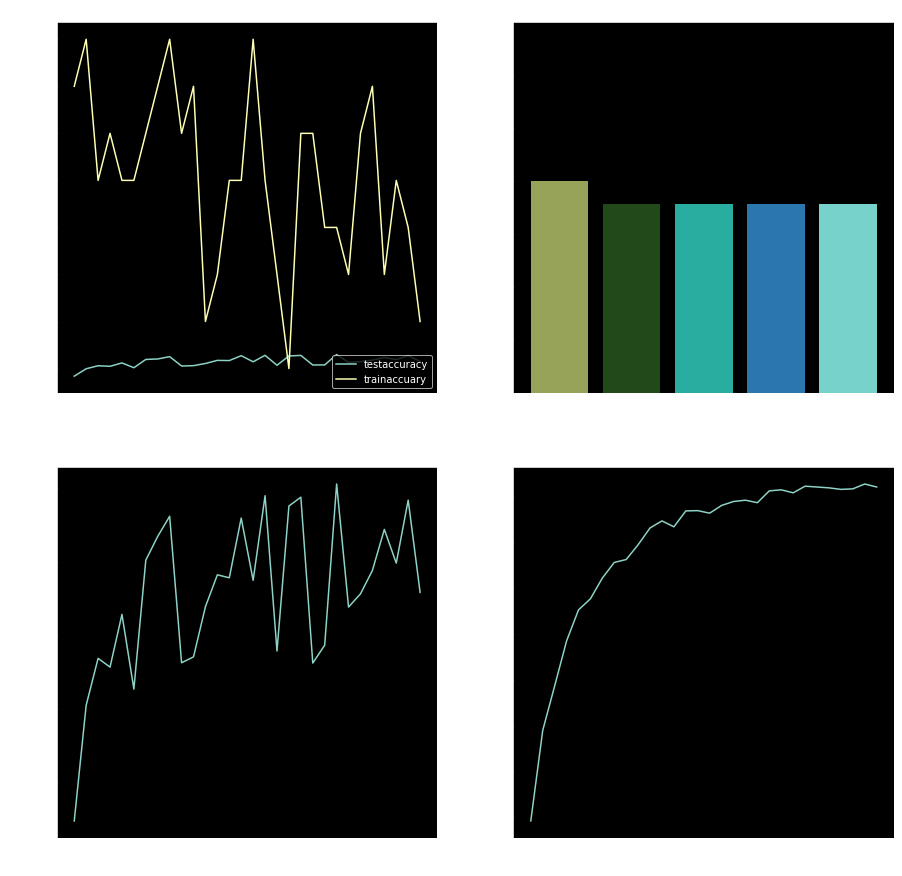

In [52]:
M6_2.visualizeMLP()

#### 6.2.1 Evaluation
The model performed almost equal than without Regression. There is a small positive improvement on the test accuracy but the curve of the train accuracy seems to having a hard time.
Let's see what happens when we use the better model of the batch-normalisation chapter.

### 6.3 Adam with batchnormalisation

In [ ]:
#Adam with batchnormalisation
M6_3 = MLP()
M6_3.train_model(epochs,model_bN2,ext_opt = optimizerADAM)

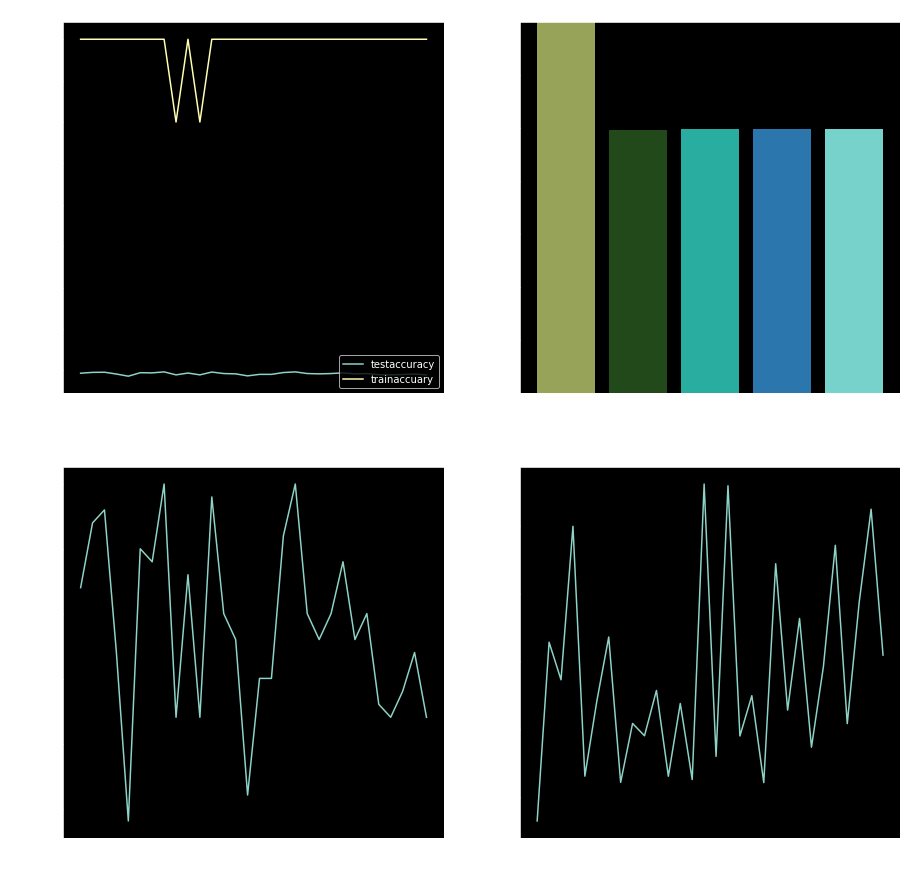

In [54]:
M6_3.visualizeMLP()

#### 6.3.1 Evaluation
The model shoots right to 80% Accuracy and does not change much at all. It is interesting that the Adam optimizer is capable of hitting a optimum with just one epoch.
But while the train accuracy is most at the time at 100% witch is the reason why the test accuracy is not changing much. Let's see what happens when we regularise the model.

### 6.4 Adam with batchnormalisation with L2 Regularisation

In [ ]:
M6_4 = MLP()
M6_4.train_model(epochs,model_bN2,ext_opt = optimizerADAMW)

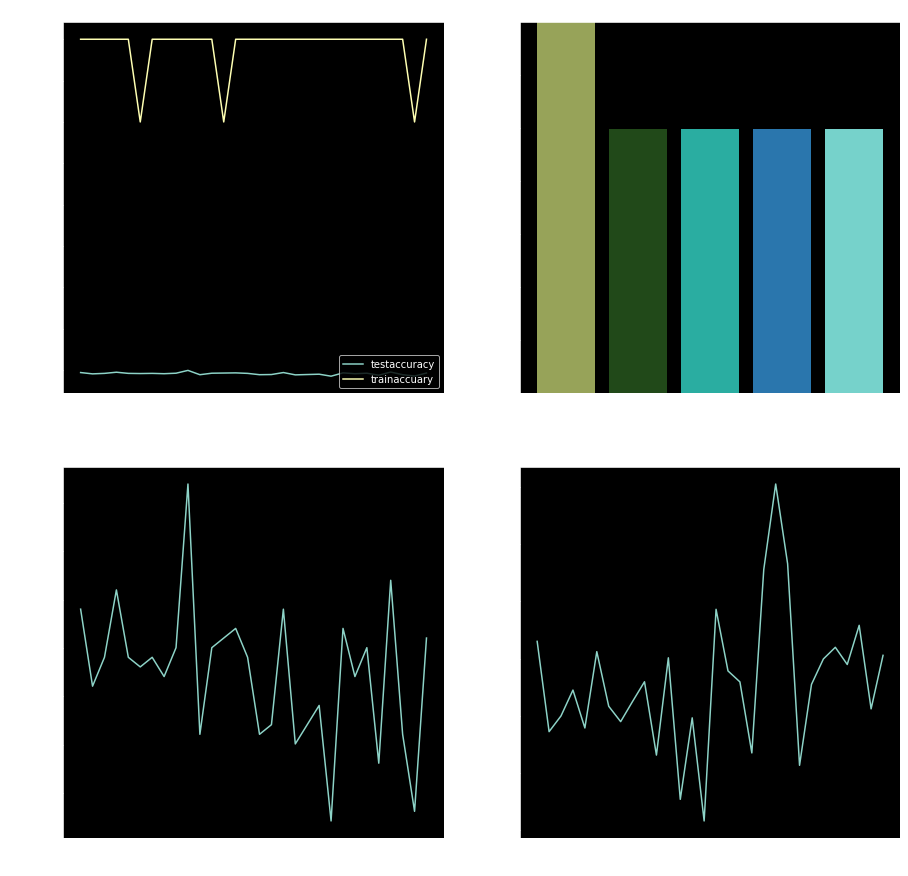

In [56]:
M6_4.visualizeMLP()

#### 6.4.1 Evaluation
Unfortunately the effect is not really visible. Let's see if the Drop-out is performing better.

### 6.5 Adam with Dropout

In [ ]:
M6_5 = MLP()
M6_5.train_model(epochs,model_drop,ext_opt = optimizerADAM)

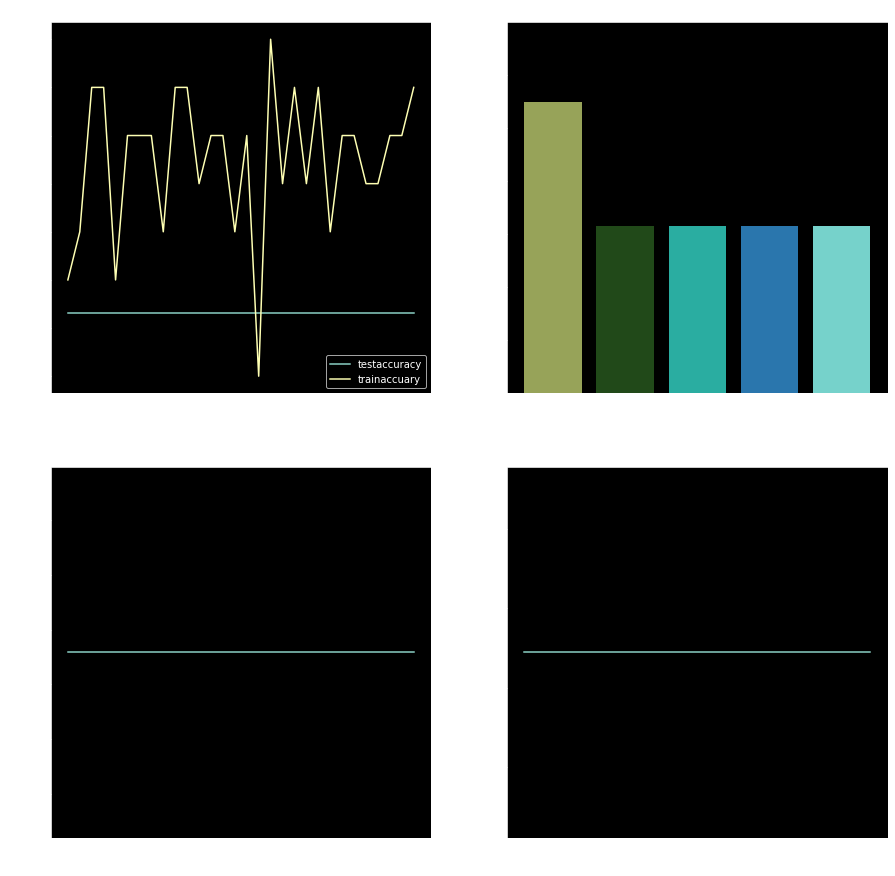

In [58]:
M6_5.visualizeMLP()

#### 6.5.1 Evaluation
The negative effect is even more effecting the test accuracy. This was done with the model from chapter 3.2 So lets see what happens whith the more complex model with a drop out and the Adam optimizer

### 6.6 Adam with Batchnorm and Dropout

In [59]:
class NetbN3(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1   = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2   = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3   = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(4*4*256, 128)
        self.fc2 = nn.Linear(128, 84)
        self.fc3 = nn.Linear(84, 10)
        self.drop= nn.Dropout(0.6)
        
    def forward(self, x):
        x = self.bn1(self.conv1(x))
        x = self.pool1(self.relu1(x))
        x = self.bn2(self.conv2(x))
        x = self.pool2(self.relu2(x))
        x = self.bn3(self.conv3(x))
        x = self.pool3(self.relu3(x))
        s = x.view((x.shape[0], -1))
        s = self.fc1(s)
        s = self.drop(s)
        s = self.fc2(s)
        s = self.fc3(s)
        return s

In [60]:
netbN3 = NetbN3()
netbN3.to(device)
model_bN3 = NetbN3().to(device)
summary(model_bN3, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
      BatchNorm2d-10            [-1, 256, 8, 8]             512
             ReLU-11            [-1, 256, 8, 8]               0
        MaxPool2d-12            [-1, 256, 4, 4]               0
           Linear-13                  [-1, 128]         524,416
          Dropout-14                  [

In [ ]:
M6_6 = MLP()
M6_6.train_model(epochs,model_bN3)

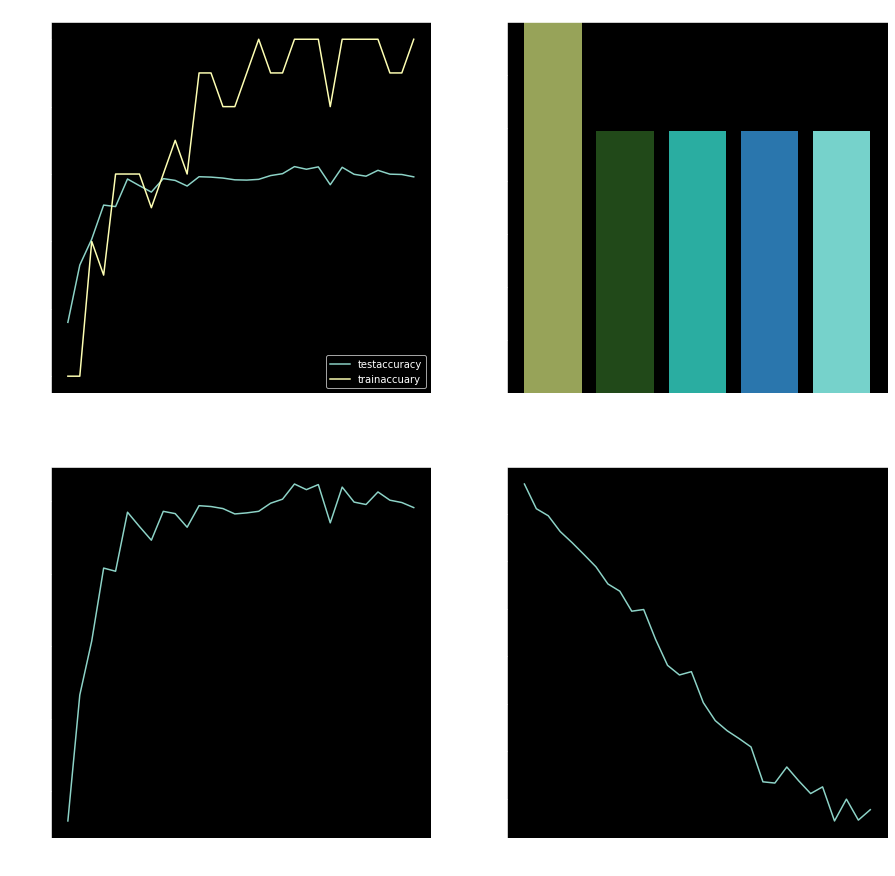

In [62]:
M6_6.visualizeMLP()

#### 6.6.1 Evaluation
The model is performing good but is at the end not better than without dropout.

### 6.7 Adam with batchnrom dropout with the more complex model

In [ ]:
M6_7 = MLP()
M6_7.train_model(epochs,model_bN3,ext_opt=optimizerADAM)

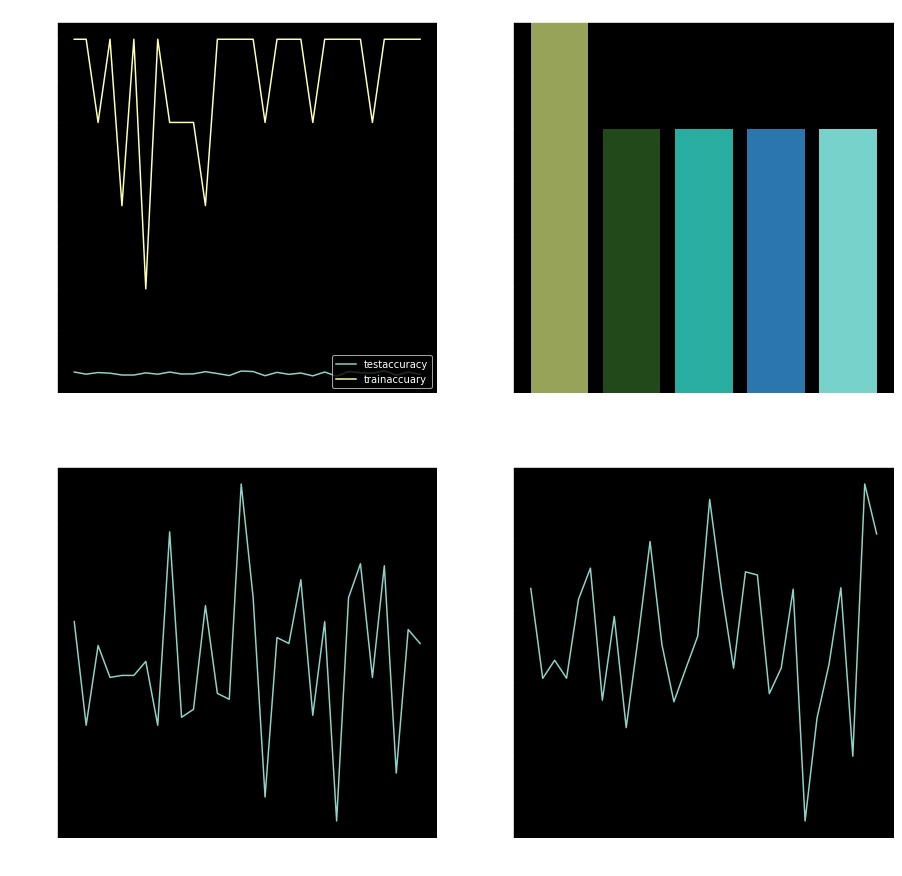

In [64]:
M6_7.visualizeMLP()

### 6.8 Adam with Batchnorm and Regularisation with the more complex model

In [ ]:
M6_8 = MLP()
M6_8.train_model(epochs,model_bN2,ext_opt=optimizerADAMW)

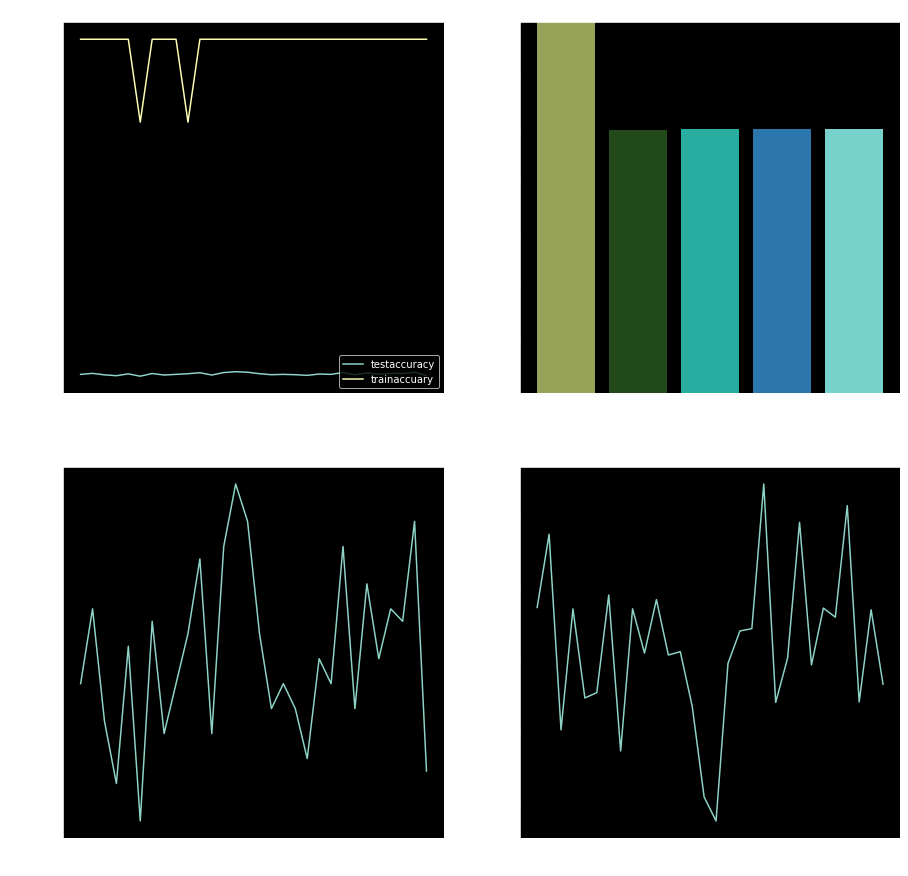

In [66]:
M6_8.visualizeMLP()

#### 6.8.1 Evaluation
The model performing really similar than the regularised model.


## 7 All Models plot

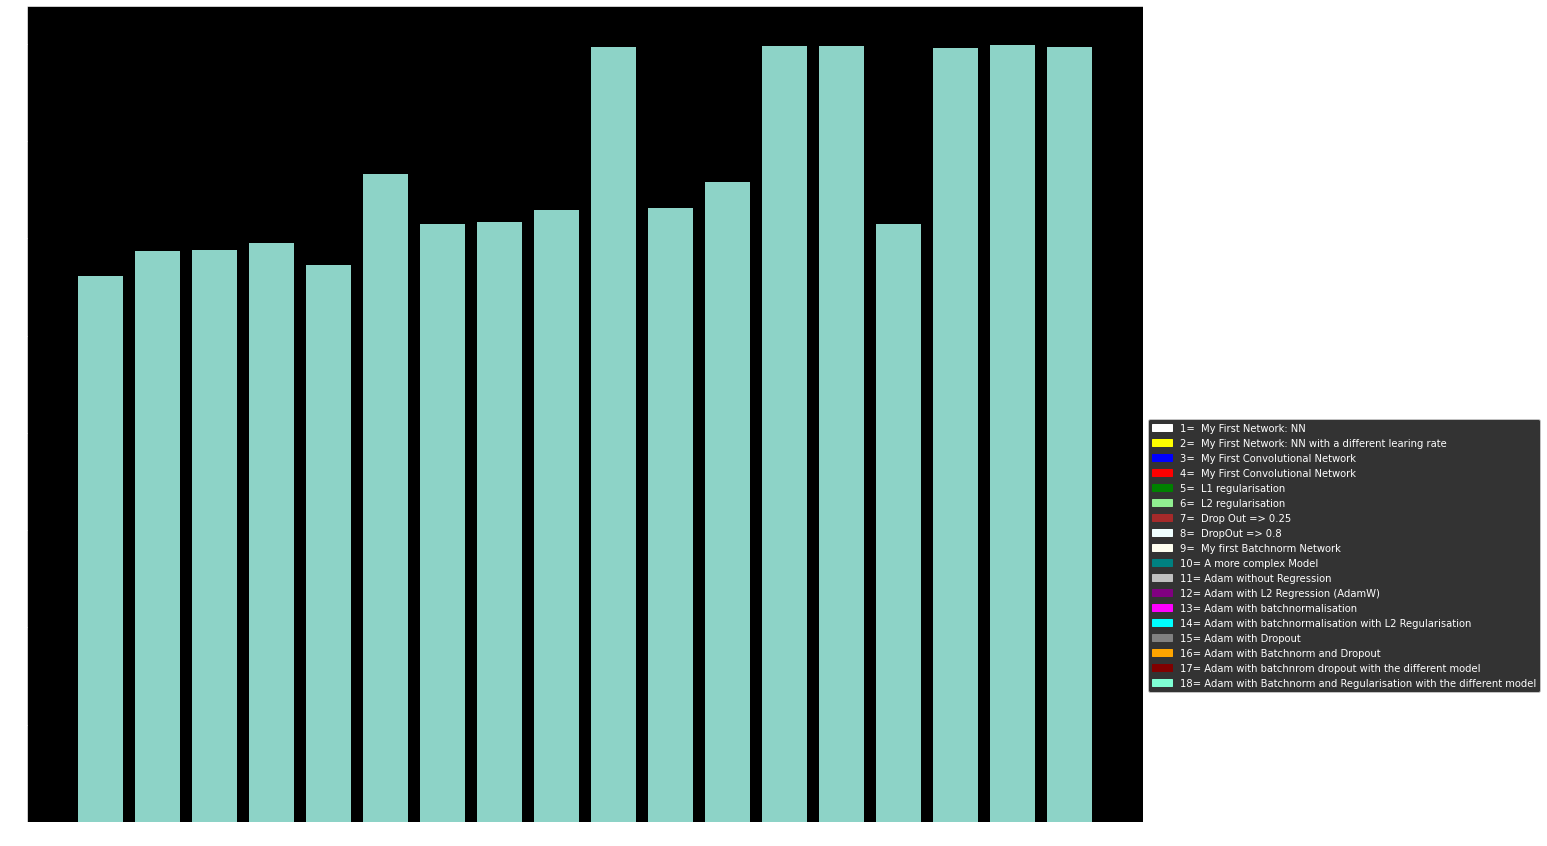

In [78]:
colors = {"1=  My First Network: NN":"White",
          "2=  My First Network: NN with a different learing rate":"Yellow",
          "3=  My First Convolutional Network":"Blue",
          "4=  My First Convolutional Network":"Red",
          "5=  L1 regularisation":"Green",
          "6=  L2 regularisation":"lightgreen",
          "7=  Drop Out => 0.25":"Brown",
          "8=  DropOut => 0.8":"Azure",
          "9=  My first Batchnorm Network":"Ivory",
          "10= A more complex Model":"Teal",
          "11= Adam without Regression":"Silver",
          "12= Adam with L2 Regression (AdamW)":"Purple",
          "13= Adam with batchnormalisation":"Fuchsia",
          "14= Adam with batchnormalisation with L2 Regularisation":"Cyan",
          "15= Adam with Dropout":"Gray",
          "16= Adam with Batchnorm and Dropout":"Orange",
          "17= Adam with batchnrom dropout with the different model":"Maroon",
          "18= Adam with Batchnorm and Regularisation with the different model":"Aquamarine"}



plt.subplots(figsize=(20,15))
plt.bar(list(map(str, range(1,19))),
       [
        M3_1.test_acc[-1],
        M3_2.test_acc[-1],
        M3_3.test_acc[-1],
        M3_4.test_acc[-1],
        M4_1.test_acc[-1],
        M4_2.test_acc[-1],
        M4_3_1.test_acc[-1],
        M4_3_2.test_acc[-1],
        M5_1.test_acc[-1],
        M5_2.test_acc[-1],
        M6_1.test_acc[-1],
        M6_2.test_acc[-1],
        M6_3.test_acc[-1],
        M6_4.test_acc[-1],
        M6_5.test_acc[-1],
        M6_6.test_acc[-1],
        M6_7.test_acc[-1],
        M6_8.test_acc[-1]
       ])

labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1,color=colors[label]) for label in labels]
plt.legend(handles, labels,bbox_to_anchor=(1, 0.5))
plt.show()

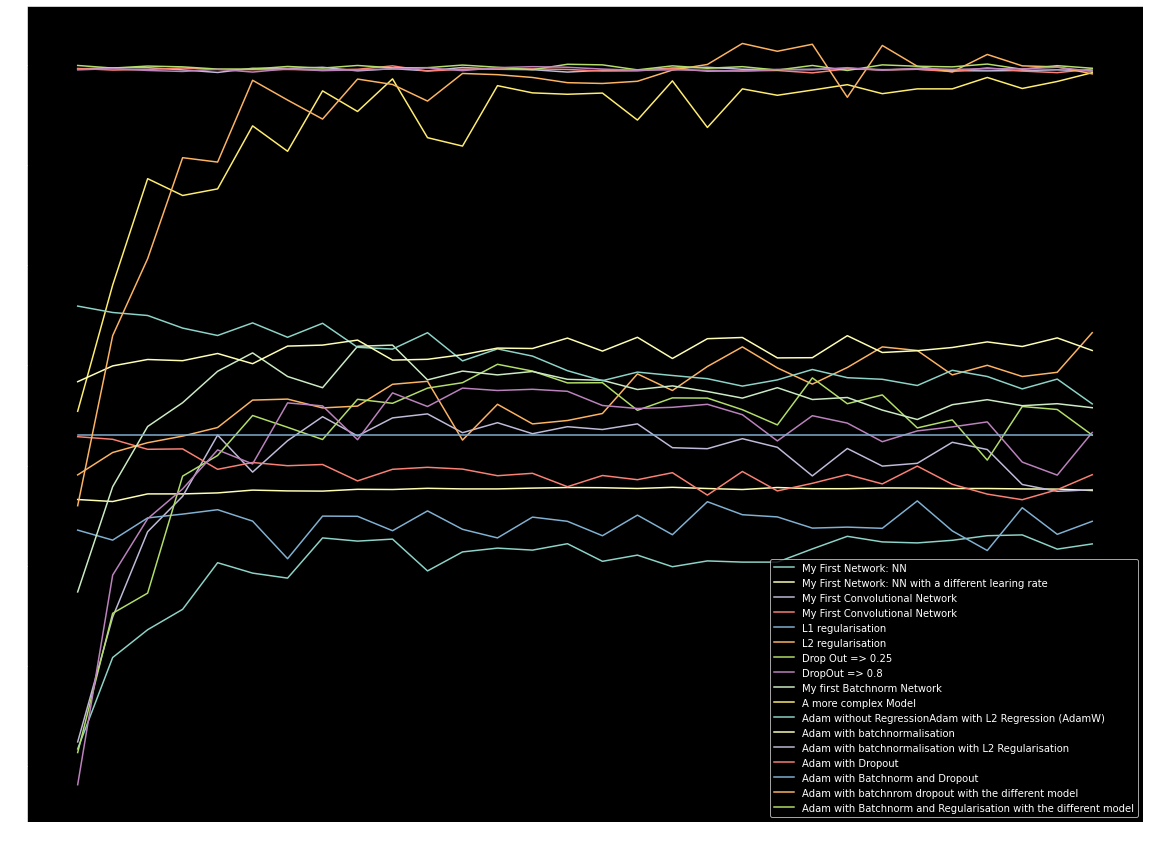

In [79]:

plt.subplots(figsize=(20,15))
plt.plot(range(epochs), M3_1.test_acc)
plt.plot(range(epochs), M3_2.test_acc)
plt.plot(range(epochs), M3_3.test_acc)
plt.plot(range(epochs), M3_4.test_acc)
plt.plot(range(epochs), M4_1.test_acc)
plt.plot(range(epochs), M4_2.test_acc)
plt.plot(range(epochs), M4_3_1.test_acc)
plt.plot(range(epochs), M4_3_2.test_acc)
plt.plot(range(epochs), M5_1.test_acc)
plt.plot(range(epochs), M5_2.test_acc)
plt.plot(range(epochs), M6_1.test_acc)
plt.plot(range(epochs), M6_2.test_acc)
plt.plot(range(epochs), M6_3.test_acc)
plt.plot(range(epochs), M6_4.test_acc)
plt.plot(range(epochs), M6_5.test_acc)
plt.plot(range(epochs), M6_6.test_acc)
plt.plot(range(epochs), M6_7.test_acc)
plt.plot(range(epochs), M6_8.test_acc)

plt.legend([
 "My First Network: NN",
 "My First Network: NN with a different learing rate",
 "My First Convolutional Network",
 "My First Convolutional Network",
 "L1 regularisation",
 "L2 regularisation",
 "Drop Out => 0.25",
 "DropOut => 0.8",
 "My first Batchnorm Network",
 "A more complex Model",
 "Adam without Regression"
 "Adam with L2 Regression (AdamW)",
 "Adam with batchnormalisation",
 "Adam with batchnormalisation with L2 Regularisation",
 "Adam with Dropout",
 "Adam with Batchnorm and Dropout",
 "Adam with batchnrom dropout with the different model",
 "Adam with Batchnorm and Regularisation with the different model"])

plt.show()

## 8 Sources
- [1] https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53
- [2] https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
- [3] https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/